In [343]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from copy import deepcopy

### 1. Read nodes and demand information, 
- x and y are coordinate of the node.
- label 0 means deport, where all the vehicle stored at time = 0
- label 1 means pick-up requirement
- label 2 means drop-off requirement
- pick-up node 1 corresponds to drop-off node 6, i.e. 1 - 6, 2 - 7, ...

In [414]:
nodes = pd.read_csv('Pickup and deliver.csv', index_col = 'node')
nodes

,x,y,label
node,,,
0,0.000000,0.000000,0
1,-2.578360,-2.189990,1
2,-3.682280,-1.408570,1
3,1.848372,0.752895,1
4,-3.099600,4.402963,1
5,-1.551850,-0.260790,1
6,4.211534,-3.435790,2
7,0.169566,-0.854430,2
8,3.137681,1.081198,2


#### Extract drop off nodes for reference

In [415]:
df_drop_off = nodes.loc[nodes['label'] == 2]
drop_off = list(df_drop_off.index)
drop_off

[6, 7, 8, 9, 10]

#### Create origin - destination pairs from nodes

In [416]:
OD = dict()
number_demand = int((len(nodes.index) - 1) / 2)
for i in range(1, number_demand + 1):
    key = (nodes.index[i], nodes.index[i + number_demand])
    OD[key] = 1 # if unserved
OD

{(1, 6): 1, (2, 7): 1, (3, 8): 1, (4, 9): 1, (5, 10): 1}

### 2. Define necessary classes and functions

#### Define vehicle

In [417]:
class vehicle():
    def __init__(self):
        self.x = 0  # x coordinate
        self.y = 0  # y coordinate
        self.customer = 0 # number of customers
        self.path = list() # path assigned to this vehicle
        self.visited = list()
        
    def update_pos(self, x, y):
        self.x = x
        self.y = y
        
    def add_customer(self, customer):
        self.customer += customer
        
    def update_path(self, path):
        self.path = path
        
    def update_visited(self, node):
        self.visited.append(node)

#### Define a function that inserts a new OD pair into an existing path
- Pick-up is always ahead of drop-off
- Return all possible paths

In [418]:
# for simplicity, assume len(path) <= 4 for capacity <= 2
def insert(path, new_OD):
    paths = list()
    O = new_OD[0]
    D = new_OD[1]
    for i in range(len(path) + 1):
        path1 = deepcopy(path)
        path1.insert(i, O)
        k = path1.index(O) + 1
        for j in range(k, len(path1) + 1):
            path2 = path1.copy()
            path2.insert(j, D)
            paths.append(path2)
            
    return paths

#### Define a function to update vehicle's position, load, and path

In [419]:
# update position and drop-offs
def update(vehs, speed, dt, drop_off):

    d = speed * dt
    vehs_new = list()
    
    for veh in vehs:
        
        if len(veh.path) > 0:
            
            # obtain a list of unvisited nodes
            visited = veh.visited
            #print('visited: ', veh.visited)
            #print('veh.path: ', veh.path)
            unvisited = deepcopy(veh.path)
            for node in veh.path:
                if node in visited:
                    unvisited.remove(node)
            #print('unvisited: ', unvisited)        
            # calculate the distance of vehicle to all unvisited nodes      
            dist = list()
            n1 = unvisited[0]
            #print('n1: ', n1)
            x1 = nodes['x'][n1]
            y1 = nodes['y'][n1]
            dist_1_0 = distance(veh.x, veh.y, x1, y1)
            
            # if not over reach, calcultate the distance based on (veh -> n1)
            if d < dist_1_0:
                sign = 1
                if x1 < veh.x:
                    sign = -1
                direct = (veh.y - y1) / (veh.x - x1)
                dx = (1 / (1 + direct ** 2)) ** 0.5 * d
                dy = direct * dx
                veh.x = veh.x + sign * dx
                veh.y = veh.y + sign * dy
            
            # if over reach, calculate distance based on (n1 -> n2) 
            else:
                
                # if there is still next node
                if len(unvisited) > 1:
                    delta_d = d - dist_1_0
                    n2 = unvisited[1]
                    x2 = nodes['x'][n2]
                    y2 = nodes['y'][n2]
                    
                    sign = 1
                    if x2 < x1:
                        sign = -1
                    direct = (y2 - y1) / (x2 - x1)
                    dx = (1 / (1 + direct ** 2)) ** 0.5 * delta_d
                    dy = direct * dx
                    veh.x = x1 + sign * dx
                    veh.y = y1 + sign * dy
                
                # all the nodes are visited, the vehicle shall stay on the final position until further notice
                else:
                    veh.x = x1
                    veh.y = y1
                    
                # add n1 to visited node
                veh.update_visited(n1)
                veh.path.remove(n1)
                #veh.update_path(veh.path.remove(n1))
                
                # if n1 is a drop-off node
                if n1 in drop_off:
                    print('drop a customer')
                    veh.add_customer(-1)
                
            vehs_new.append(veh)
            
        else:
            vehs_new.append(veh)
            
    return vehs_new

#### Define if all the OD pairs are served (not used for now)

In [420]:
def all_served_check(OD):
    all_served = True
    for key in OD.keys():
        if OD[key] == 1:
            all_served = False
    return all_served

#### Auxilary functions to calculate 
1. point-point distance
2. path total length

In [421]:
# auxilary function to calculate distance
def distance(x1, y1, x2, y2):
    dist = (x1 - x2) ** 2 + (y1 - y2) ** 2
    dist = dist ** 0.5
    return dist

def distance_path(vehx, vehy, path, nodes):
    n1 = path[0]
    x1 = nodes['x'][n1]
    y1 = nodes['y'][n1]
    dist0 = distance(vehx, vehy, x1, y1)
    
    for i in range(len(path) - 1):
        n1 = path[i]
        n2 = path[i + 1]
        x1 = nodes['x'][n1]
        y1 = nodes['y'][n1]
        x2 = nodes['x'][n2]
        y2 = nodes['y'][n2]
        dist0 += distance(x1, y1, x2, y2)
        
    return dist0

### 3. Main function

--- t =  0 :   demand  (1, 6)
veh  0 :
   path:  [1, 6]
   load:  1
   position: [ 0 , 0 ]
veh  1 :
   path:  []
   load:  0
   position: [ 0 , 0 ]
total_distance:  10.29


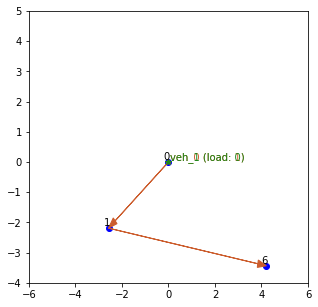

--- t =  1 :   demand  (2, 7)
veh  0 :
   path:  [2, 1, 7, 6]
   load:  2
   position: [ -0.76 , -0.65 ]
veh  1 :
   path:  []
   load:  0
   position: [ 0 , 0 ]
total_distance:  13.22


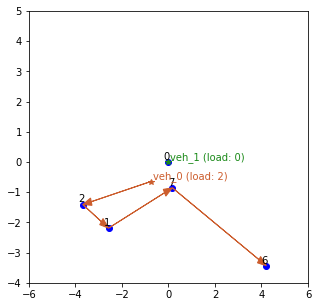

--- t =  2 :   demand  (3, 8)
veh  0 :
   path:  [2, 1, 7, 6]
   load:  2
   position: [ -1.73 , -0.9 ]
veh  1 :
   path:  [3, 8]
   load:  1
   position: [ 0 , 0 ]
total_distance:  16.55


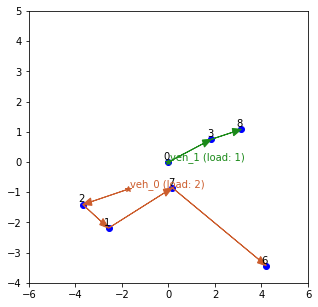

--- t =  3 :   demand  (4, 9)
veh  0 :
   path:  [2, 1, 7, 6]
   load:  2
   position: [ -2.7 , -1.15 ]
veh  1 :
   path:  [3, 8, 4, 9]
   load:  2
   position: [ 0.93 , 0.38 ]
total_distance:  29.37


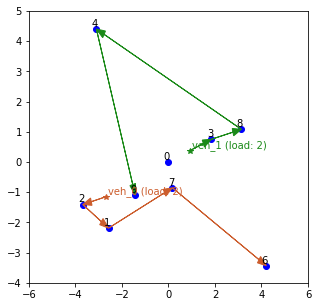

--- t =  4 :   demand  (5, 10)
veh  0 :
   path:  [2, 1, 7, 6]
   load:  2
   position: [ -3.67 , -1.4 ]
veh  1 :
   path:  [8, 4, 9]
   load:  2
   position: [ 1.85 , 0.75 ]
total_distance:  29.37


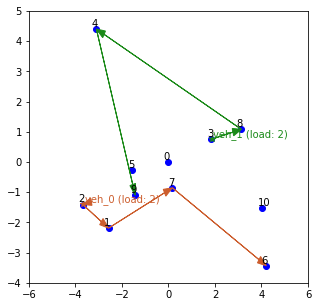

In [433]:
# define customer capacity
customer_cap = 2

# define fleet size
n_v = 2

# initiate vehicles and colors for plot purpose
vehs = list()
for v in range(n_v):
    vehs.append(vehicle())
    
# initialize total travel length
total_distance = 0

# initialize time
t = 0

# define initial OD pairs, speed, and time step
OrDes = [0]
speed = 1
dt = 1

for OrDe in OD.keys():
    
    candidate_vehs = list()
    
    # loop over all vehicles to find shortest increase of total distance
    for veh in vehs:

        # if this vehicle still has extra capacity, add task to it
        if veh.customer < customer_cap:
            
            # if this vehicle has a path already, insert a new path
            if len(veh.path) > 0:
                
                # find all possible paths
                paths = insert(veh.path, OrDe)
                #print('paths: ', paths)
                dist_min = np.inf
                path_sel = paths[0]

                # find the path with minimum length
                for path in paths:
                    
                    dist0 = distance_path(veh.x, veh.y, path, nodes)
                    # record minimum length and the corresponding path
                    if dist0 < dist_min:
                        dist_min = dist0
                        dist_add = dist_min - distance_path(veh.x, veh.y, veh.path, nodes)
                        path_sel = path
                        
            # else, append the new OrDe pair to it    
            else:
                O = OrDe[0]
                D = OrDe[1]
                dist_min = distance(veh.x, veh.y, nodes['x'][O], nodes['y'][O])
                dist_min += distance(nodes['x'][O], nodes['y'][O], nodes['x'][D], nodes['y'][D])
                dist_add = dist_min
                path_sel = list(OrDe)
                
            # record vehicle id, min distance added, and the corresponding path        
            candidate_vehs.append([vehs.index(veh), dist_add, path_sel])
        
        #print('veh_sel: ', vehs.index(veh), '. dist_add: ', dist_add, '. path_sel: ', path_sel)
    
    if len(candidate_vehs) > 0:
        # compare candidate vehicles, select the one with minimum dist_add
        df_cv = pd.DataFrame(candidate_vehs, columns = ['id', 'dist_add', 'path'])

        total_distance += df_cv['dist_add'].min()
        index = df_cv[['dist_add']].idxmin()

        veh_index = int(df_cv['id'][index])
        path_sel = list(df_cv['path'][index])[0]
        vehs[veh_index].add_customer(1)
        vehs[veh_index].update_path(list(path_sel))
    
    
    # print and plot
    print('--- t = ', t, ': ', ' demand ', OrDe)
    #print('veh selected (id): ', veh_index)
    
    temp = list(OrDe)
    for ele in temp:
        OrDes.append(ele)
    df_OrDes = nodes[nodes.index.isin(OrDes)]
    x = list(df_OrDes['x'])
    y = list(df_OrDes['y'])
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.scatter(x, y, marker = 'o', color = 'blue')
    
    for i, label in enumerate(list(df_OrDes.index)):
        ax.annotate(label, (x[i], y[i]), xytext = (x[i] - 0.2, y[i] + 0.08))
        
    for i in range(len(vehs)):
        print('veh ', i, ':')
        print('   path: ', vehs[i].path)
        print('   load: ', vehs[i].customer)
        print('   position: [', round(vehs[i].x, 2) , ',',round(vehs[i].y, 2), ']')
        
        colors = ['#cc5d2d', '#1b8a19', '#8a7019', '#19198a', '#8a1979']
        ax.plot(vehs[i].x, vehs[i].y, marker = '*', color = colors[i])
        label = 'veh_' + str(i) + ' (load: ' + str(vehs[i].customer) + ')'
        ax.annotate(label, (vehs[i].x, vehs[i].y), xytext = (vehs[i].x + 0.08, vehs[i].y + 0.08), color = colors[i])
        xp = [vehs[i].x]
        yp = [vehs[i].y]
        for node in vehs[i].path:
            xp.append(nodes['x'][node])
            yp.append(nodes['y'][node])
        for ixp in range(len(xp) - 1):
            dxp = xp[ixp + 1] - xp[ixp]
            dyp = yp[ixp + 1] - yp[ixp]
            ax.arrow(xp[ixp], yp[ixp], dxp, dyp, head_width = 0.25, color = colors[i], length_includes_head = True)
        #ax.plot(xp, yp)
        ax.set_xlim(-6, 6)
        ax.set_ylim(-4, 5)
    
    print('total_distance: ', round(total_distance,2))
    plt.show()
    #print('------')
    
    # Update vehicles position
    t += dt
    
    # plotfunction(vehs)
    vehs = update(vehs, speed, dt, drop_off)